In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
import numpy as np
import pandas as pd 
import os
import pickle
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from keras.preprocessing.image import ImageDataGenerator
import warnings
from tensorflow.keras.applications.efficientnet import EfficientNetB7

warnings.filterwarnings("ignore")

2022-05-17 07:33:08.106987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 07:33:08.107024: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_path = "./train"
test_path = "./test"

In [3]:
def process_data(img_dims, batch_size):
  train_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_gen = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
  )

  test_gen = test_datagen.flow_from_directory(
      directory=test_path,
      target_size=(img_dims, img_dims),
      batch_size=batch_size,
      class_mode='binary',
      shuffle=True
  )

  return (train_gen, test_gen)

In [4]:
img_dims = 160
epochs=10
batch_size=16

train_gen, test_gen = process_data(img_dims, batch_size)

Found 12134 images belonging to 2 classes.
Found 2615 images belonging to 2 classes.


In [5]:
efficientnetb7 = EfficientNetB7(input_shape=(160, 160, 3), weights='imagenet', include_top=False)

for layer in efficientnetb7.layers:
    layer.trainable = False

regularizer = L2(l2=0.001)

x = Flatten()(efficientnetb7.output)
prediction = Dense(2048, activation='relu')(x)
prediction = Dense(1024, activation='relu')(prediction)
prediction = Dense(512, activation='relu')(prediction)
prediction = Dense(256, activation='relu')(prediction)
prediction = Dense(64, activation='relu')(prediction)
prediction = Dense(32, activation='relu')(prediction)
prediction = Dense(1, activation='sigmoid')(prediction)

model  = Model(inputs=efficientnetb7.input, outputs=prediction)

model.summary()

2022-05-17 07:33:15.511477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dhiraj/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-17 07:33:15.511504: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 07:33:15.511557: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dhiraj-Inspiron-5593): /proc/driver/nvidia/version does not exist
2022-05-17 07:33:15.511766: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 160, 160, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 160, 160, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 161, 161, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [8]:
model.compile(loss='binary_crossentropy', metrics=['accuracy', 'FalseNegatives', 'FalsePositives', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives'], optimizer='adam')

In [9]:
hist = model.fit(
  train_gen,
  batch_size=16,
  epochs=10, validation_data=test_gen,
  verbose=1
)

Epoch 1/10
759/759 [==============================] - 1636s 2s/step - loss: 0.7163 - accuracy: 0.5448 - false_negatives: 5192.0000 - false_positives: 331.0000 - precision: 0.4418 - recall: 0.0480 - true_negatives: 6349.0000 - true_positives: 262.0000 - val_loss: 0.6786 - val_accuracy: 0.6252 - val_false_negatives: 980.0000 - val_false_positives: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_negatives: 1635.0000 - val_true_positives: 0.0000e+00
Epoch 2/10
759/759 [==============================] - 1408s 2s/step - loss: 0.6914 - accuracy: 0.5499 - false_negatives: 5434.0000 - false_positives: 27.0000 - precision: 0.4255 - recall: 0.0037 - true_negatives: 6653.0000 - true_positives: 20.0000 - val_loss: 0.6761 - val_accuracy: 0.6252 - val_false_negatives: 980.0000 - val_false_positives: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_negatives: 1635.0000 - val_true_positives: 0.0000e+00
Epoch 3/10
759/759 [============================

In [10]:
model.save("efficientnetb7.h5")

In [11]:
with open('efficientnetb7_hist.pkl', 'wb') as f:
  pickle.dump(hist.history, f)

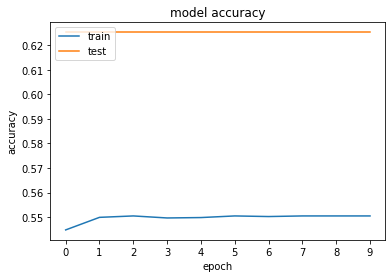

In [12]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

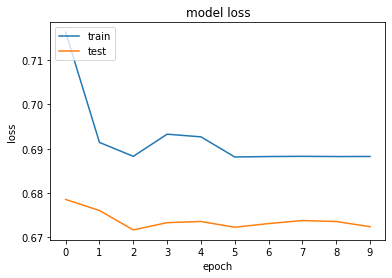

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
from tensorflow.keras.models import load_model
from keras.models import Model

model = load_model('xception.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [15]:
new_model = Model(model.input, model.layers[-3].output)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [16]:
new_model.save('effnet_for_vit.h5')